In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/home/amitdubey/cs229/updated datset/Main.csv")
df.head()

,subject_id,Demographics_Delta,Age,Date_of_Birth,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,Sex
0,121,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Female
1,226,0.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Male
2,290,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
3,624,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female
4,666,0.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Male


In [3]:
df.isnull().sum()

subject_id                              0
Demographics_Delta                     85
Age                                  3021
Date_of_Birth                       10931
Ethnicity                            8740
Race_Americ_Indian_Alaska_Native    12152
Race_Asian                          12082
Race_Black_African_American         12020
Race_Hawaiian_Pacific_Islander      12163
Race_Unknown                        12139
Race_Caucasian                       4127
Race_Other                          12356
Race_Other_Specify                  12465
Sex                                     6
dtype: int64

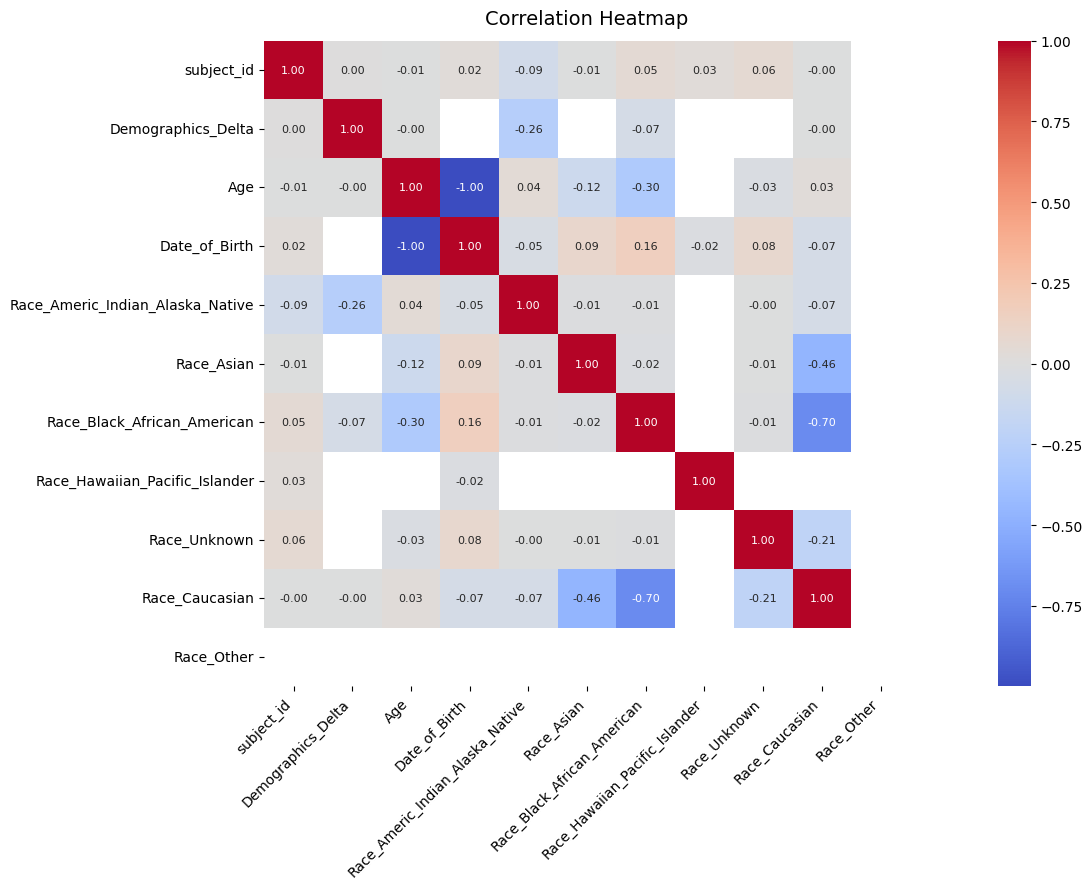

In [4]:
corr = df.select_dtypes(include='number').corr()

plt.figure(figsize=(18,9))
sns.heatmap(
    corr,
    annot=True,
    annot_kws={"size": 8},   
    cmap='coolwarm',
    fmt=".2f",
    square=True
)
plt.title("Correlation Heatmap", fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Race Column Consolidation

## Overview
We consolidate multiple race indicator columns into a single unified `Race` column to simplify analysis and ensure consistent race categorization across all records.

## Original Data Structure
The dataset contains multiple binary race indicator columns:
- `Race_Americ_Indian_Alaska_Native`
- `Race_Asian`
- `Race_Black_African_American`
- `Race_Hawaiian_Pacific_Islander`
- `Race_Unknown`
- `Race_Caucasian`
- `Race_Other`
- `Race_Other_Specify` (text field for custom entries)

Each column contains either `1` (indicating that race) or `0`/empty (not that race).

## Consolidation Logic

The function `consolidate_race()` follows a priority-based approach:

1. **Race_Other_Specify** 
   - If contains text: Use the specific race description provided
   - Example: "Mixed", "Hispanic", "Multiple races"

2. **Race_Other**
   - If value = 1: Return "Other"

3. **Specific Race Categories**
   - Checks each race column in order
   - Returns corresponding race name when value = 1:
     - American Indian/Alaska Native
     - Asian
     - Black/African American
     - Hawaiian/Pacific Islander
     - Caucasian
     - Unknown

4. **Default** (Lowest Priority)
   - If no race marked: Return "Other"

## Implementation
```python

In [5]:
def consolidate_race(row):
    if pd.notna(row.get('Race_Other_Specify')) and row.get('Race_Other_Specify') != '':
        return row['Race_Other_Specify']
    elif row.get('Race_Other') == 1:
        return 'Other'
    elif row.get('Race_Americ_Indian_Alaska_Native') == 1:
        return 'American Indian/Alaska Native'
    elif row.get('Race_Asian') == 1:
        return 'Asian'
    elif row.get('Race_Black_African_American') == 1:
        return 'Black/African American'
    elif row.get('Race_Hawaiian_Pacific_Islander') == 1:
        return 'Hawaiian/Pacific Islander'
    elif row.get('Race_Caucasian') == 1:
        return 'Caucasian'
    elif row.get('Race_Unknown') == 1:
        return 'Unknown'
    else:
        return 'Other'

df['Race'] = df.apply(consolidate_race, axis=1)

race_cols_to_drop = [
    'Race_Americ_Indian_Alaska_Native',
    'Race_Asian',
    'Race_Black_African_American',
    'Race_Hawaiian_Pacific_Islander',
    'Race_Unknown',
    'Race_Caucasian',
    'Race_Other',
    'Race_Other_Specify'
]
df_cleaned = df.drop(columns=race_cols_to_drop)

print("\nConsolidated Race distribution:")
print(df_cleaned['Race'].value_counts())


Consolidated Race distribution:
Race
Caucasian                                          8350
Other                                              3832
Black/African American                              155
Asian                                                87
Unknown                                              26
HISPANIC                                             14
American Indian/Alaska Native                        14
NOT REPORTED DUE TO CONFIDENTIALITY REGULATIONS       7
EAST INDIAN                                           1
CAUCASIAN / AMERICAN INDIAN                           1
INDIAN(EAST)                                          1
FILIPINO                                              1
NORTH AMERICAN INDIAN                                 1
MEXICAN                                               1
GREEK                                                 1
CHICANO/SPANISH                                       1
INDIAN DESCENT                                        1
NATIVE AME

# Age Calculation from Date of Birth

## Overview
This code calculates patient ages from the `Date_of_Birth` column, which contains dates encoded as days since the Unix epoch (January 1, 1970).

## Date Format
- **Negative values**: Days *before* January 1, 1970 (e.g., -20473 = ~56 years ago)
- **Positive values**: Either already calculated ages or days *after* January 1, 1970
- **Missing/Empty**: Falls back to existing `Age` column value

## Logic Flow
1. **Check Date_of_Birth**
   - If positive and < 150: Treat as age directly
   - If negative or > 150: Convert from Unix epoch days to birth date
   - Calculate age: (current_date - birth_date) / 365

2. **Fallback to Age column**
   - If Date_of_Birth is missing/invalid
   - Uses existing Age value if available and non-zero

3. **Validation**
   - Ages must be between 0-150 years
   - Invalid calculations return `None`

## Example Conversions
| Date_of_Birth | Calculation | Resulting Age |
|---------------|-------------|---------------|
| -20473 | 1970-01-01 - 20473 days | ~56 years |
| -24970 | 1970-01-01 - 24970 days | ~68 years |
| 56 | Direct age value | 56 years |
| (empty) | Use Age column | (from Age) |

## Usage
```python
df['Age'] = df.apply(calculate_age, axis=1)
```

## Output
Updates the `Age` column with calculated values where Date_of_Birth is available.

In [6]:

current_date = datetime.now()

def calculate_age(row):
    dob = row.get('Date_of_Birth')
    
    if pd.notna(dob) and dob != '':
        try:
            dob_num = float(dob)
            if dob_num > 0 and dob_num < 150:  
                return int(dob_num)
            else:
                
                birth_date = pd.Timestamp('1970-01-01') + pd.Timedelta(days=dob_num)
                age = (current_date - birth_date).days // 365
                return int(age) if age >= 0 and age < 150 else None
        except:
            pass
    
    
    age = row.get('Age')
    if pd.notna(age) and age != '' and age != 0:
        return int(age)
    
    return None

df['Age'] = df.apply(calculate_age, axis=1)

print("Age statistics:")
print(df['Age'].describe())
print("\nSample of calculated ages:")
print(df[['subject_id', 'Date_of_Birth', 'Age']].head(20))

NameError: name 'datetime' is not defined

In [ ]:
df_cleaned.isnull().sum()

# 🧹 Handling Missing Values in Age Column

## 📌 Filling Missing (NaN) Values with Median

### Overview
We fill missing values in the `Age` column using the **median** to maintain data integrity without being affected by outliers.

### Result
All missing (`NaN`) values in the `Age` column are replaced with the median age value, ensuring no gaps in the data for analysis.

In [ ]:
sns.histplot(df_cleaned['Age'].dropna(), kde=True, color='blue', bins=10)

In [ ]:
median = df['Age'].median()
std = df['Age'].std()
outliers = (df['Age'] - median).abs() > std
df[outliers] = np.nan
df_cleaned['Age'].fillna(median, inplace=True)

In [ ]:
df_cleaned

# 📊 Race Distribution Analysis

## 📌 Overview
We visualize the distribution of people across different race categories to understand the demographic composition of the dataset and identify any imbalances.

## 🎯 Purpose
- Check how many people are in each race category
- Identify dominant and minority groups
- Assess data imbalance for analysis considerations


/tmp/ipykernel_6763/1196879437.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_of_people.index, y=no_of_people.values, palette='viridis')


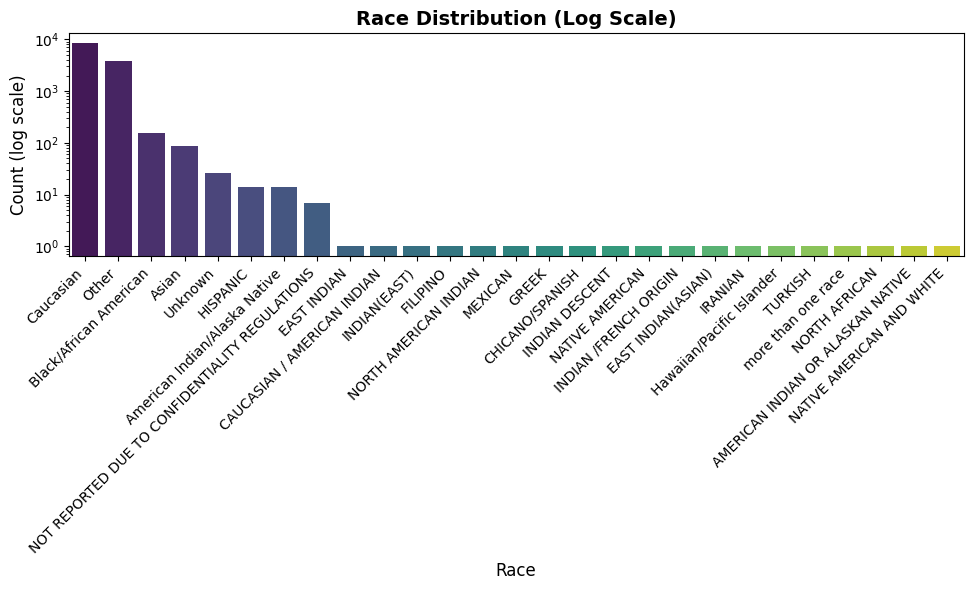

In [7]:
no_of_people = df_cleaned["Race"].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=no_of_people.index, y=no_of_people.values, palette='viridis')
plt.xlabel('Race', fontsize=12)
plt.ylabel('Count (log scale)', fontsize=12)
plt.yscale('log')  # Log scale to see small values better
plt.title('Race Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 📊 Race "Other" Category Analysis

## 📌 Overview
We analyze the `Race_Other` and `Race_Other_Specify` columns to understand what specific races or categories are grouped under "Other" in the dataset.

## 🎯 Purpose
- Identify specific race descriptions in the "Other" category
- Count how many people fall into each subcategory
- Determine if "Other" categories can be further consolidated or reclassified

Race_Other_Specify values:
Race_Other_Specify
HISPANIC                                           14
NOT REPORTED DUE TO CONFIDENTIALITY REGULATIONS     7
EAST INDIAN                                         1
INDIAN(EAST)                                        1
CAUCASIAN / AMERICAN INDIAN                         1
FILIPINO                                            1
NORTH AMERICAN INDIAN                               1
MEXICAN                                             1
GREEK                                               1
CHICANO/SPANISH                                     1
INDIAN DESCENT                                      1
NATIVE AMERICAN                                     1
INDIAN /FRENCH ORIGIN                               1
EAST INDIAN(ASIAN)                                  1
IRANIAN                                             1
TURKISH                                             1
more than one race                                  1
NORTH AFRICAN                       

/tmp/ipykernel_6763/836722785.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=other_counts.index, y=other_counts.values, palette='Set2')


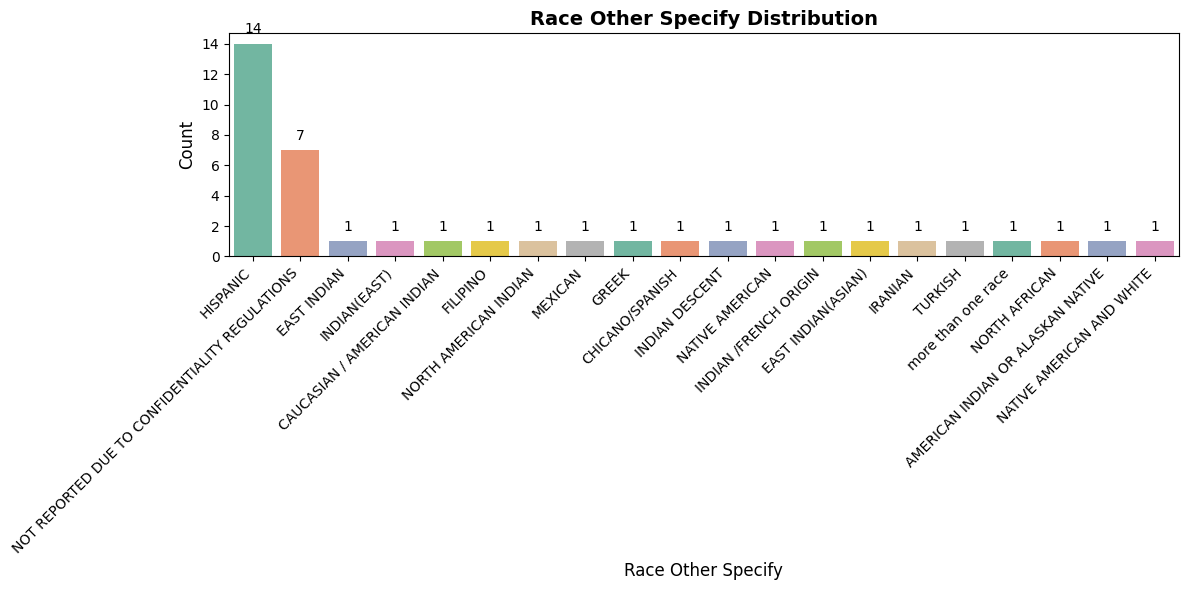

In [8]:
df_cleaned["other"] = df['Race_Other_Specify'].astype(str) + " " + df['Race_Other'].astype(str)

other_specify = df[df['Race_Other_Specify'].notna() & (df['Race_Other_Specify'] != '')]

other_counts = df['Race_Other_Specify'].value_counts()

print("Race_Other_Specify values:")
print(other_counts)
print(f"\nTotal entries: {len(other_specify)}")

plt.figure(figsize=(12, 6))
sns.barplot(x=other_counts.index, y=other_counts.values, palette='Set2')
plt.xlabel('Race Other Specify', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Race Other Specify Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(other_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# 📊 Race "Other" Category Analysis

## 📌 Overview
We analyze the `Race_Other` and `Race_Other_Specify` columns to understand what specific races or categories are grouped under "Other" in the dataset.

## 🎯 Purpose
- Identify specific race descriptions in the "Other" category
- Count how many people fall into each subcategory
- Determine if "Other" categories can be further consolidated or reclassified

Sex Distribution:
Sex
Male      7610
Female    4888
Name: count, dtype: int64

Total participants: 12498


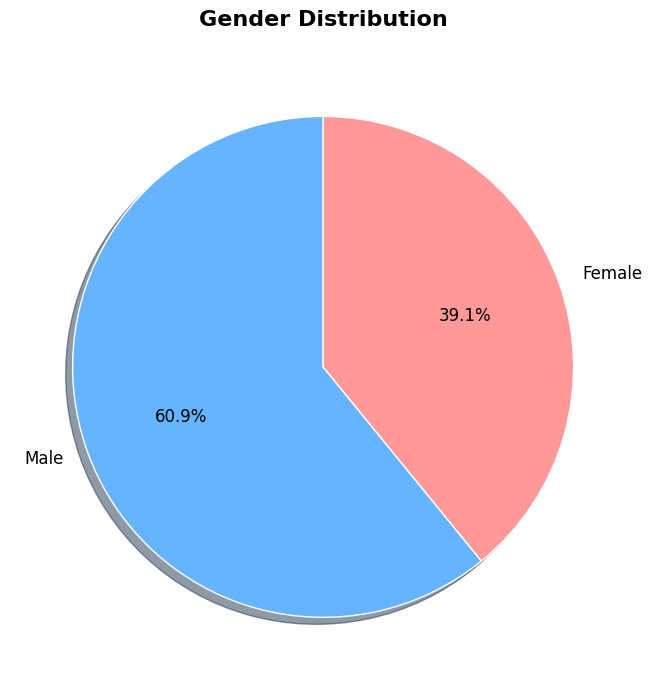

In [11]:
sex_counts = df['Sex'].value_counts()
print("Sex Distribution:")
print(sex_counts)
print(f"\nTotal participants: {sex_counts.sum()}")

plt.figure(figsize=(7, 7))
plt.pie(
    sex_counts.values,
    labels=sex_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    colors=['#66b3ff', '#ff9999'],
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Gender Distribution', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 📊 Race and Gender Distribution Analysis

## 📌 Overview
We visualize the distribution of participants across different race categories, segmented by gender (sex) to understand demographic patterns.

## 🎯 Purpose
- Compare gender distribution within each race category
- Identify patterns of gender imbalance across races
- Assess intersectionality of race and gender in the dataset


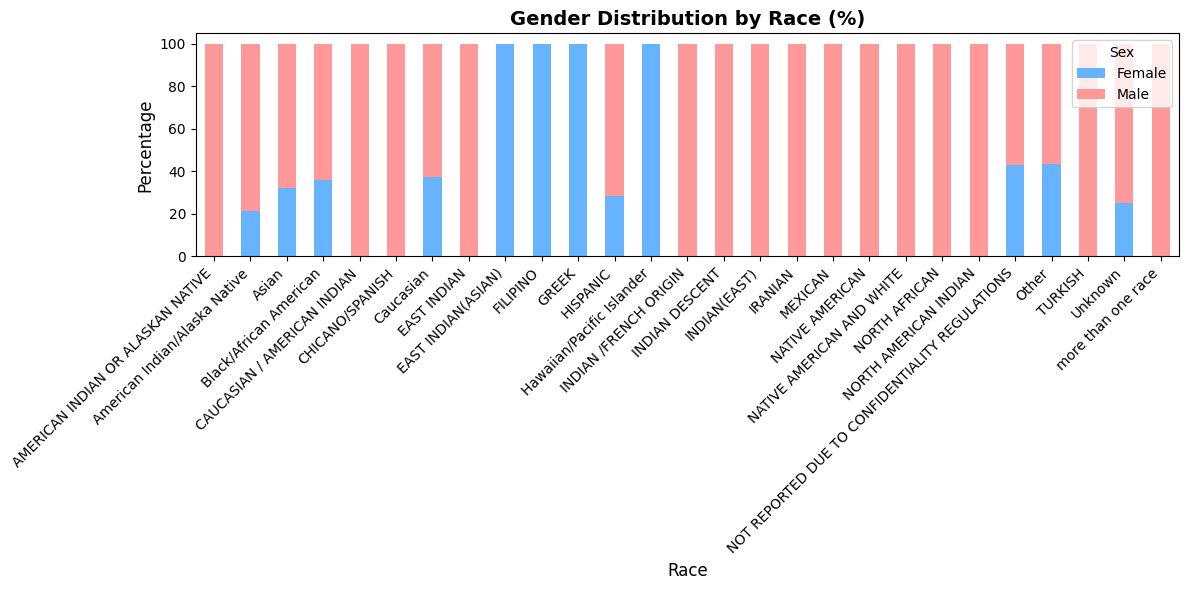

In [12]:
race_sex_counts = pd.crosstab(df_cleaned['Race'], df_cleaned['Sex'])
race_sex_pct = race_sex_counts.div(race_sex_counts.sum(axis=1), axis=0) * 100

race_sex_pct.plot(kind='bar', stacked=True, figsize=(12, 6), 
                   color=['#66b3ff', '#ff9999'])
plt.title("Gender Distribution by Race (%)", fontsize=14, fontweight='bold')
plt.xlabel("Race", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(title='Sex', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
df2=pd.read_csv("/home/amitdubey/cs229/Dataset/2025_05_27_PROACT_ALL_FORMS/PROACT_DEATHDATA.csv")
df2

,subject_id,Subject_Died,Death_Days
0,121,Yes,504.0
1,226,Yes,393.0
2,624,Yes,324.0
3,1110,Yes,243.0
4,1333,Yes,275.0
...,...,...,...
5038,999217,Yes,57.0
5039,999234,Yes,88.0
5040,999367,Yes,207.0
5041,999649,No,NaN


# 🔍 Identifying Missing `subject_id` in Death Data

## 📌 Overview
We are comparing two datasets to identify discrepancies in patient records between the main dataset and death records.

## 📊 Datasets

### Dataset 1: `df` but working now on `df_cleaned` (Main Data)
- Contains primary patient demographic and clinical information
- Key identifier: `subject_id`
- Columns: Demographics, Age, Date_of_Birth, Ethnicity, Race, Sex, etc.

### Dataset 2: `df2` (Death Data)
- Contains patient death records and survival information
- Key identifier: `subject_id`
- Columns: `subject_id`, `Subject_Died`, `Death_Days`



In [14]:
missing_in_df2=df[~df_cleaned['subject_id'].isin(df2['subject_id'])]
missing_in_df2

,subject_id,Demographics_Delta,Age,Date_of_Birth,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,Sex,Race
2,290,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,Other
4,666,0.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Male,Caucasian
5,671,0.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Female,Caucasian
6,935,0.0,45.0,NaN,Non-Hispanic or Latino,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Female,Caucasian
7,1009,0.0,51.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Male,Black/African American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12497,999528,0.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,Other
12498,999638,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,Other
12500,999836,0.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Male,Caucasian
12502,999882,0.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Male,Caucasian


In [15]:
df_merged = pd.merge(df_cleaned, df2, on='subject_id', how='inner')
df_merged.drop('Date_of_Birth', axis=1, inplace=True)
df_merged

,subject_id,Demographics_Delta,Age,Ethnicity,Sex,Race,other,Subject_Died,Death_Days
0,121,0.0,52.0,NaN,Female,Caucasian,nan nan,Yes,504.0
1,226,0.0,72.0,NaN,Male,Caucasian,nan nan,Yes,393.0
2,624,0.0,NaN,NaN,Female,Other,nan nan,Yes,324.0
3,1110,0.0,NaN,Non-Hispanic or Latino,Male,Asian,nan nan,Yes,243.0
4,1333,0.0,55.0,Non-Hispanic or Latino,Female,Caucasian,nan nan,Yes,275.0
...,...,...,...,...,...,...,...,...,...
5038,999217,0.0,54.0,NaN,Male,Caucasian,nan nan,Yes,57.0
5039,999234,0.0,NaN,NaN,Female,Other,nan nan,Yes,88.0
5040,999367,0.0,64.0,NaN,Female,Caucasian,nan nan,Yes,207.0
5041,999649,0.0,56.2,Non-Hispanic or Latino,Male,Caucasian,nan nan,No,NaN


In [16]:
df_merged['Death_Days'].isnull().sum()
df_merged.isnull().sum()

subject_id               0
Demographics_Delta      84
Age                   1324
Ethnicity             3339
Sex                      0
Race                     0
other                    0
Subject_Died             0
Death_Days            1507
dtype: int64

In [17]:
df_merged['Ethnicity'].fillna("Unkown",inplace=True)

/tmp/ipykernel_6763/3626538792.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Ethnicity'].fillna("Unkown",inplace=True)


In [18]:
df_merged

,subject_id,Demographics_Delta,Age,Ethnicity,Sex,Race,other,Subject_Died,Death_Days
0,121,0.0,52.0,Unkown,Female,Caucasian,nan nan,Yes,504.0
1,226,0.0,72.0,Unkown,Male,Caucasian,nan nan,Yes,393.0
2,624,0.0,NaN,Unkown,Female,Other,nan nan,Yes,324.0
3,1110,0.0,NaN,Non-Hispanic or Latino,Male,Asian,nan nan,Yes,243.0
4,1333,0.0,55.0,Non-Hispanic or Latino,Female,Caucasian,nan nan,Yes,275.0
...,...,...,...,...,...,...,...,...,...
5038,999217,0.0,54.0,Unkown,Male,Caucasian,nan nan,Yes,57.0
5039,999234,0.0,NaN,Unkown,Female,Other,nan nan,Yes,88.0
5040,999367,0.0,64.0,Unkown,Female,Caucasian,nan nan,Yes,207.0
5041,999649,0.0,56.2,Non-Hispanic or Latino,Male,Caucasian,nan nan,No,NaN


In [17]:
df_merged.to_csv('Main1.csv')